In [15]:
##### Load packages #####
library(tidyverse)
library(multcomp)
library(ggplot2)
library(car)
library(MASS)
library(stats)
library(sjPlot)
library(tidyverse)
library(lme4)
library(lmerTest)
library(LMERConvenienceFunctions)
library(multcomp)

In [16]:
# Load CSV
dir_name <- basename(getwd())
csv_file <- paste0(dir_name, ".csv")
graphdata <- read.csv(csv_file)

Trial_list <- c("Trial01", "Trial02", "Trial03", "Trial04", "Trial05", "Trial06", "Trial07", "Trial08", "Trial09", "Trial10")

#add column index
colnames(graphdata) <- paste0(sprintf("%02d", seq_along(colnames(graphdata))), " ", colnames(graphdata))

# Identify rows with NA (used to detect the gaps) in graphdata
gap_rows <- which(rowSums(is.na(graphdata)) == ncol(graphdata))

# Assign groups dynamically using Trial_list
graphdata$Group <- NA  # Initialize Group column

# Create a sequence of rows to handle gaps
gap_rows <- c(0, gap_rows, nrow(graphdata) + 1)  # Include start and end boundaries
current_trial_index <- 1  # Start from the first trial in Trial_list

# Assign groups dynamically
for (i in seq_along(gap_rows[-1])) {
  start <- gap_rows[i] + 1  # Start of the current block
  end <- gap_rows[i + 1] - 1  # End of the current block
  
  if (start <= end) {
    graphdata$Group[start:end] <- Trial_list[current_trial_index]
    current_trial_index <- current_trial_index + 1
    
    # Loop back to the start of Trial_list if necessary
    if (current_trial_index > length(Trial_list)) {
      current_trial_index <- 1
    }
  }
}

# Print the result to check
print(head(graphdata))

# Reshape graphdata to long format and keep Group in the third column
stacked_graphdata <- graphdata %>%
  pivot_longer(cols = -Group,  # Exclude the Group column from pivoting
               names_to = "ind",  # Column names will go to 'ind'
               values_to = "values") %>%  # Data will go to 'values'
  relocate(Group, .after = ind)  # Move Group column to the third position

# View the result
print(head(stacked_graphdata))

# Create the tallcsv dataframe with renamed columns
tallcsv <- stacked_graphdata %>%
  rename(
    VALUE = values,       
    Treatment = ind,      
    Trial = Group         
  ) %>%
  arrange(Trial, Treatment)  

# View the resulting dataframe
print(head(tallcsv))

#delete NA row
tallcsv2 <- tallcsv[!is.na(tallcsv$VALUE),]

#export
csv_file2 <- paste0(dir_name, "_tall.csv")
write.csv(tallcsv2,csv_file2, row.names = FALSE)

    01 Mock  02 RG.I   03 OGs 04 flg22   Group
1 1.0129782 22.21302       NA 80.63495 Trial01
2 1.0893325 23.64287       NA 83.47853 Trial01
3 0.9062321 22.36752       NA 80.07796 Trial01
4        NA       NA       NA       NA    <NA>
5 1.0129782       NA 29.86324 74.55840 Trial02
6 1.0893325       NA 28.64674 64.45851 Trial02
# A tibble: 6 × 3
  ind      Group   values
  <chr>    <chr>    <dbl>
1 01 Mock  Trial01   1.01
2 02 RG.I  Trial01  22.2 
3 03 OGs   Trial01  NA   
4 04 flg22 Trial01  80.6 
5 01 Mock  Trial01   1.09
6 02 RG.I  Trial01  23.6 
# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 Mock   Trial01  1.01 
2 01 Mock   Trial01  1.09 
3 01 Mock   Trial01  0.906
4 02 RG.I   Trial01 22.2  
5 02 RG.I   Trial01 23.6  
6 02 RG.I   Trial01 22.4  


# A tibble: 6 × 3
  Treatment Trial    VALUE
  <chr>     <chr>    <dbl>
1 01 Mock   Trial01  1.01 
2 01 Mock   Trial01  1.09 
3 01 Mock   Trial01  0.906
4 02 RG.I   Trial01 22.2  
5 02 RG.I   Trial01 23.6  
6 02 RG.I   Trial01 22.4  


[1] 27 25

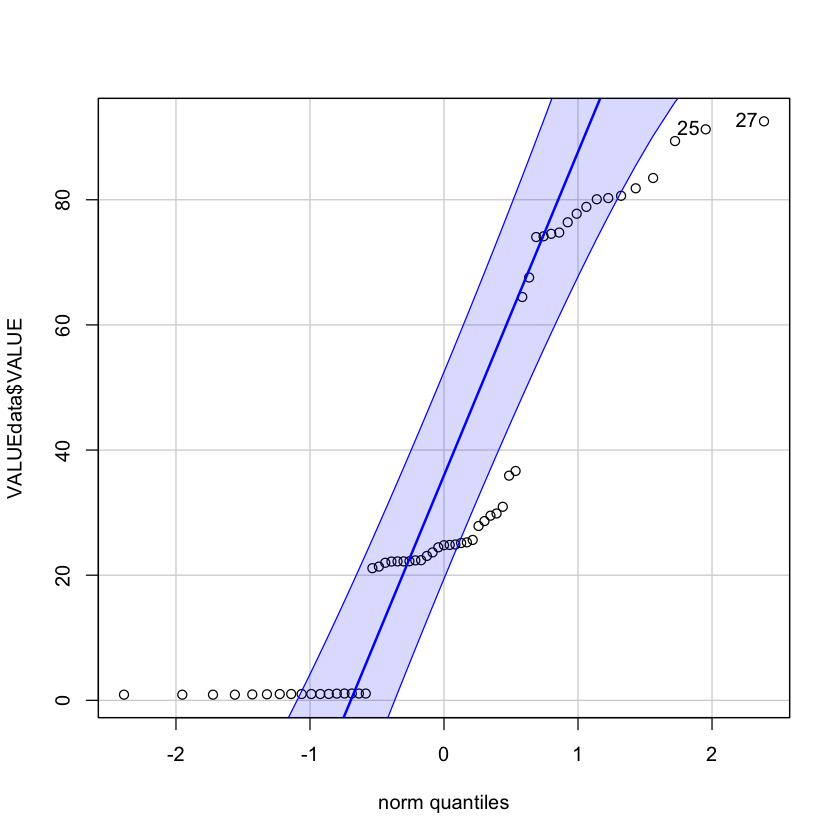

In [17]:
#VALUEdata=read.csv(choose.files())
VALUEdata <- tallcsv2
VALUEdata$VALUE <- as.numeric(as.character(VALUEdata$VALUE))
print(head(VALUEdata))
#Normal distribution
qqp(VALUEdata$VALUE, "norm")

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: VALUE ~ Treatment + (1 | Trial)
   Data: VALUEdata

     AIC      BIC   logLik deviance df.resid 
   362.6    375.0   -175.3    350.6       53 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-3.03209 -0.59996 -0.05907  0.22368  2.63812 

Random effects:
 Groups   Name        Variance Std.Dev.
 Trial    (Intercept)  1.543   1.242   
 Residual             21.163   4.600   
Number of obs: 59, groups:  Trial, 5

Fixed effects:
                  Estimate Std. Error     df t value Pr(>|t|)    
(Intercept)          1.044      1.248 20.407   0.836    0.413    
Treatment02 RG.I    25.088      1.671 55.255  15.012   <2e-16 ***
Treatment03 OGs     24.125      1.807 57.157  13.353   <2e-16 ***
Treatment04 flg22   77.942      1.578 53.271  49.397   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (In

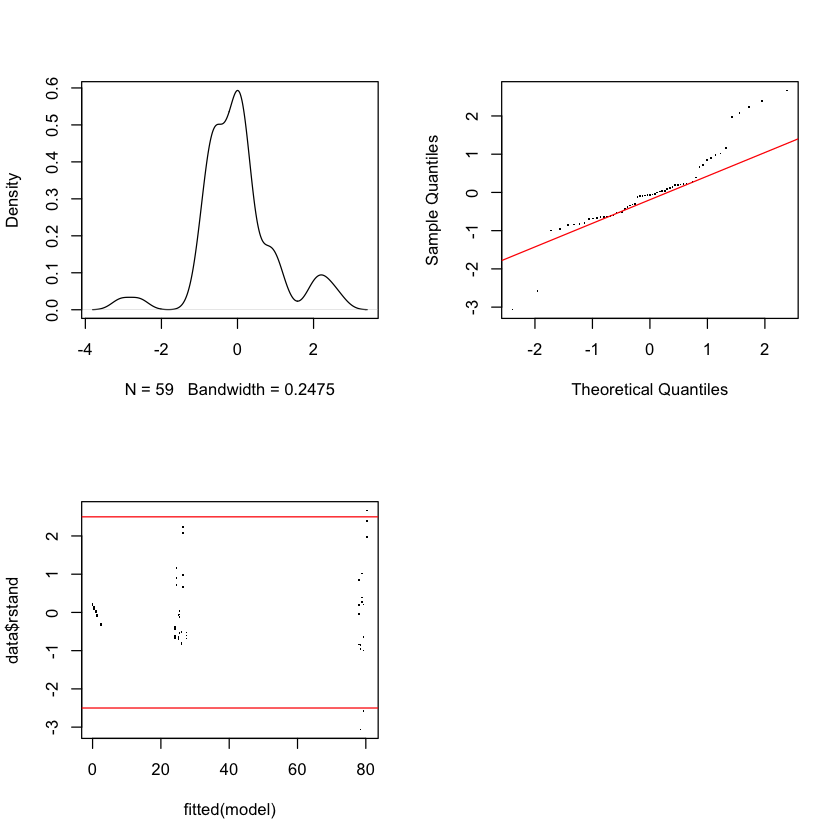

In [18]:
#set REML to FALSE if the data is normal, so we can use the maximum likelihood because the data are normal, we have similar sample sizes between effects, and we only have one random effect
VALUE.lmm<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
m<-lmer(VALUE ~ Treatment + (1|Trial), data = VALUEdata, REML = FALSE)
#the density plot should look roughly normal, centered on 0. In the quantile plot the black dots should roughly mirror the red line. And in the fitted residual plot most black dots should be between the red lines, with no obvious skew from left to right.
mcp.fnc(VALUE.lmm)
#If the above looks good, then we can get the model characteristics
summary(VALUE.lmm)
summary_name1 <- paste0("01.",dir_name, "_LMM_summary.txt")
capture.output(summary(VALUE.lmm), file = summary_name1)

In [20]:
#anova analysis of lmm
aov <- anova(m)
print(summary(aov))
# Save the summary to a text file
summary_name2 <- paste0("02.",dir_name, "_anova_summary.txt")
capture.output(summary(aov), file = summary_name2)

#Tukey's post-hoc, load library multcomp
tukey_result <- glht(m, linfct = mcp(Treatment = "Tukey"))
multcomps <- cld(tukey_result, alpha=0.1)
print(summary(tukey_result))
# Save the summary to a text file
summary_name3 <- paste0("03.",dir_name, "_multcomp_summary.txt")
capture.output(summary(tukey_result), file = summary_name3)

print(multcomps)
multcomp_name <- paste0("04.",dir_name, "_multcomp_letters.txt")
capture.output(print(multcomps), file = multcomp_name)

     Sum Sq         Mean Sq          NumDF       DenDF          F value     
 Min.   :54551   Min.   :18184   Min.   :3   Min.   :55.87   Min.   :859.2  
 1st Qu.:54551   1st Qu.:18184   1st Qu.:3   1st Qu.:55.87   1st Qu.:859.2  
 Median :54551   Median :18184   Median :3   Median :55.87   Median :859.2  
 Mean   :54551   Mean   :18184   Mean   :3   Mean   :55.87   Mean   :859.2  
 3rd Qu.:54551   3rd Qu.:18184   3rd Qu.:3   3rd Qu.:55.87   3rd Qu.:859.2  
 Max.   :54551   Max.   :18184   Max.   :3   Max.   :55.87   Max.   :859.2  
     Pr(>F)         
 Min.   :1.075e-46  
 1st Qu.:1.075e-46  
 Median :1.075e-46  
 Mean   :1.075e-46  
 3rd Qu.:1.075e-46  
 Max.   :1.075e-46  

	 Simultaneous Tests for General Linear Hypotheses

Multiple Comparisons of Means: Tukey Contrasts


Fit: lmer(formula = VALUE ~ Treatment + (1 | Trial), data = VALUEdata, 
    REML = FALSE)

Linear Hypotheses:
                        Estimate Std. Error z value Pr(>|z|)    
02 RG.I - 01 Mock == 0   25.0880     